# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.

## Exploración de datos y medición de $k$

In [1]:
#!pip install Numpy
#!pip install Pandas
#!pip install matplotlib
#!pip install scipy
#!pip install Pillow

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
sns.set()
from jupyterthemes import jtplot
import os
from scipy.optimize import curve_fit
from datetime import datetime
from datetime import date, timedelta

#from google.colab import drive
#from scipy.optimize import curve_fit

# Estilo del gráfico segun el thema
jtplot.style(#'chesterish'
             #'grade3'
             #'gruvboxd'
             #'gruvboxl'
             #'monokai'
             #'oceans16'
             #'onedork'
             'solarizedd'
             #'solarizedl'
            )

### a. Explorar la fuente de datos:

 * ¿ Qué representa el dataset?
 * ¿ Hay información sobre las columnas?

In [2]:
os.listdir('data')

['contagios_covid_data.csv', 'owid-covid-data.csv']

In [44]:
datos=pd.read_csv('data/contagios_covid_data.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165403,ZWE,Africa,Zimbabwe,2022-02-25,235467.0,500.0,348.143,5392.0,2.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165404,ZWE,Africa,Zimbabwe,2022-02-26,235803.0,336.0,368.429,5393.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165405,ZWE,Africa,Zimbabwe,2022-02-27,235803.0,0.0,350.143,5393.0,0.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165406,ZWE,Africa,Zimbabwe,2022-02-28,236380.0,577.0,401.286,5395.0,2.0,1.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [29]:
d = datos.date.loc[0]
d

'2020-02-24'

In [30]:
d = datetime.strptime(d,'%Y-%m-%d')
d
#d.strftime("%H:%M %d/%b/%Y")

datetime.datetime(2020, 2, 24, 0, 0)

In [32]:
cats = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
datos.date.strftime('%b').astype('category', categories=cats)
#d.strftime("%d/%b/%Y") < datetime.now()
datos

AttributeError: 'Series' object has no attribute 'strftime'

In [24]:
import calendar
print(list(calendar.month_abbr))


['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [35]:
df = pd.DataFrame(dict(Date=pd.date_range('2011-03-31', periods=4, freq='Q')))

df

,Date
0,2011-03-31
1,2011-06-30
2,2011-09-30
3,2011-12-31


In [36]:
df.Date.dt.strftime('%b').astype('category')

0    Mar
1    Jun
2    Sep
3    Dec
Name: Date, dtype: category
Categories (4, object): ['Dec', 'Jun', 'Mar', 'Sep']

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 160.0 bytes


In [45]:
#df['date'] = df['date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
datos['date']= pd.to_datetime(datos['date']) 
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165408 entries, 0 to 165407
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    165408 non-null  object        
 1   continent                                   155504 non-null  object        
 2   location                                    165408 non-null  object        
 3   date                                        165408 non-null  datetime64[ns]
 4   total_cases                                 162378 non-null  float64       
 5   new_cases                                   162230 non-null  float64       
 6   new_cases_smoothed                          160247 non-null  float64       
 7   total_deaths                                144574 non-null  float64       
 8   new_deaths                                  144611 non-null  float64      

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165408 entries, 0 to 165407
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    165408 non-null  object 
 1   continent                                   155504 non-null  object 
 2   location                                    165408 non-null  object 
 3   date                                        165408 non-null  object 
 4   total_cases                                 162378 non-null  float64
 5   new_cases                                   162230 non-null  float64
 6   new_cases_smoothed                          160247 non-null  float64
 7   total_deaths                                144574 non-null  float64
 8   new_deaths                                  144611 non-null  float64
 9   new_deaths_smoothed                         142515 non-null  float64
 

### b. Análisis exploratorio

#### 10 Países
 Los paises seleccionados son:
 * **Argentina**
 * **Colombia**
 * **Brazil**
 * **United States**
 * **China**
 * **Kazakhstan**
 * **Russia**
 * **Japan**
 * **Italy**
 * **Egypt**
 * **South Africa**
 * **Spain**

In [5]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

Text(0.5, 0.98, 'Casos Totales')

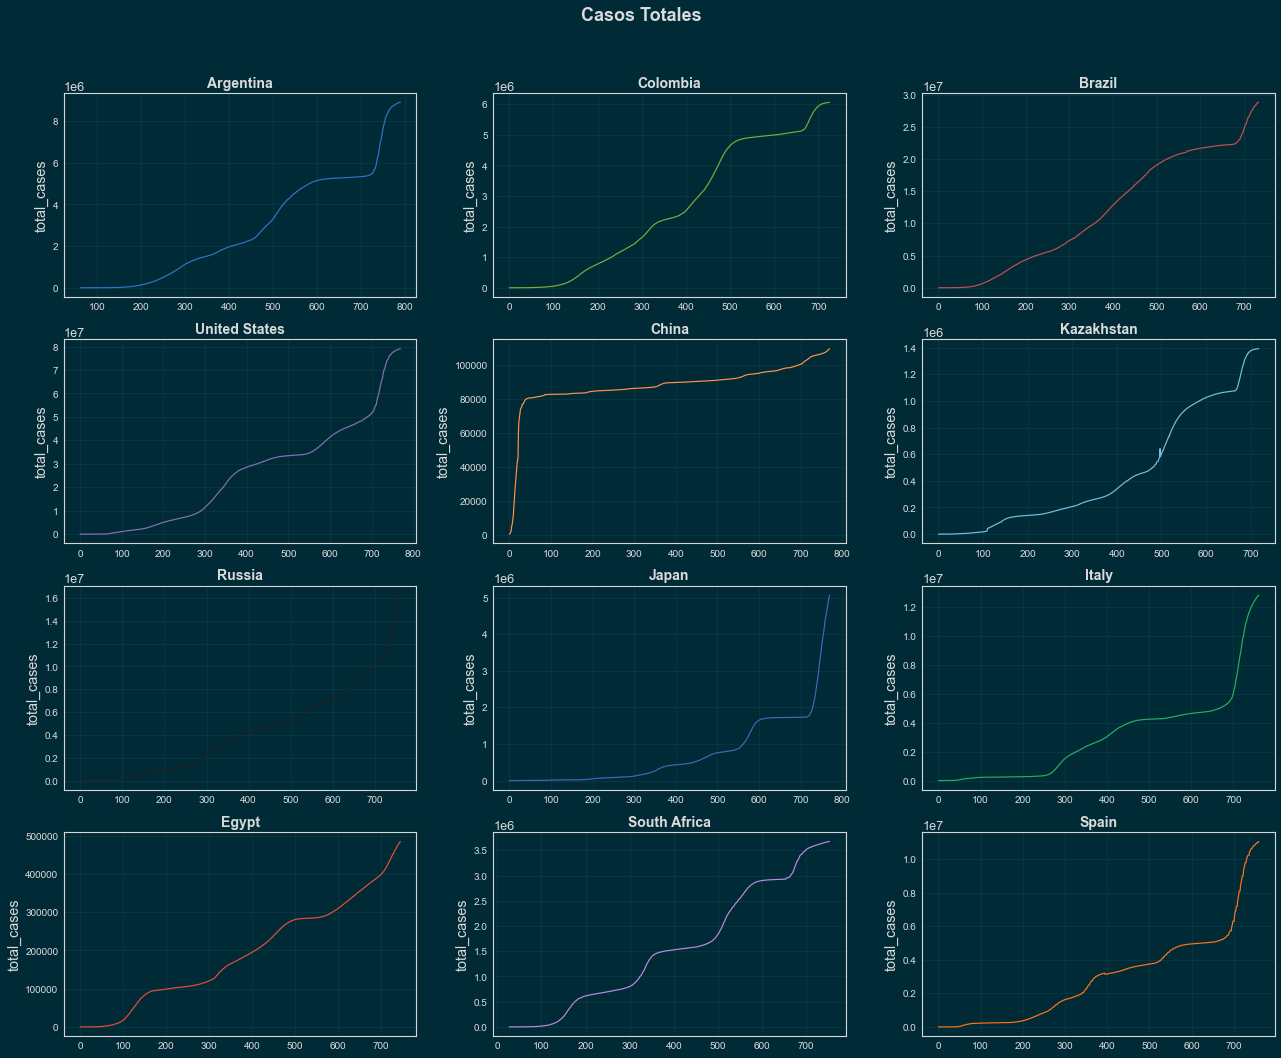

In [6]:
#seleccionamos China
#sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
axes = axes.flat

Paises = ['Argentina','Colombia','Brazil','United States',
          'China',
          'Kazakhstan',
          'Russia',
          'Japan',
          'Italy',
          'Egypt',
          'South Africa',
          'Spain'
          #,'India'
         ]

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p) #indises de pais de interes
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    #plt.figure(figsize = (15,8))
    #plt.plot(dias,casos_arg)
    #plt.xlabel('dias')
    #plt.ylabel('cantidad de casos')
    sns.lineplot(x=dias, y=casos_arg,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #markers=True,
        #dashes=True,
        #legend="full",
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Casos Totales', fontsize = 18, fontweight = "bold")

Estas son las curvas de **casos totales**. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Estas hablan de los acumulados, entonces siempre se agregan.

Para ver mejor las curvas, podemos tomar el logartimo de los datos. **Una curva exponencial se ve lineal en escala logarítmica**


Text(0.5, 0.98, 'log cantidad de casos')

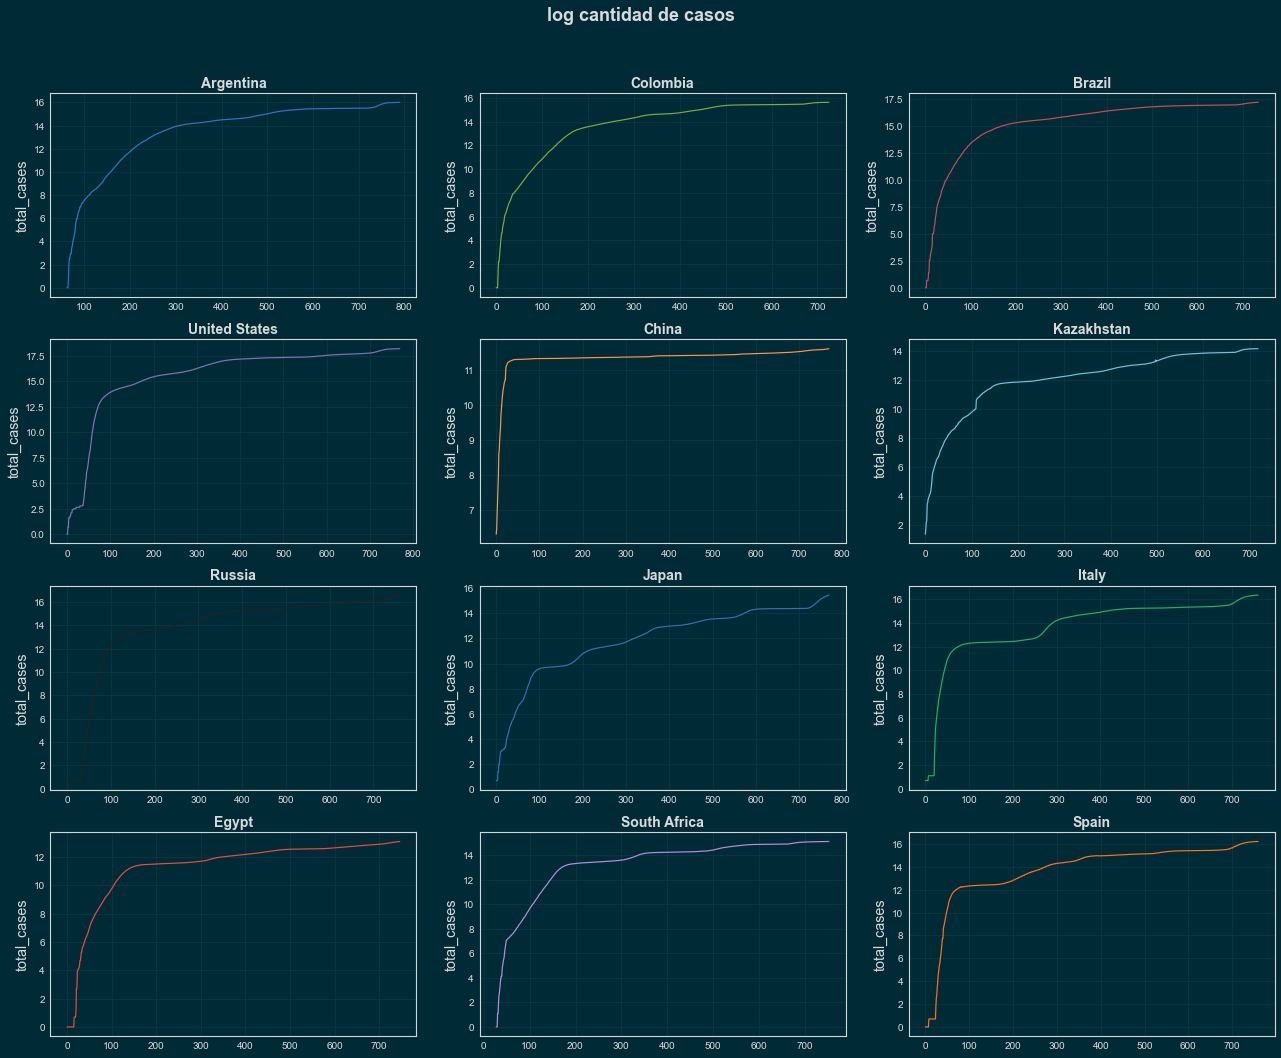

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    #plt.figure(figsize = (15,8))
    #plt.plot(dias,casos_arg)
    #plt.xlabel('dias')
    #plt.ylabel('cantidad de casos')
    sns.lineplot(x=dias, y=np.log(casos_arg),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos', fontsize = 18, fontweight = "bold")

#### Etapa inicial del crecimiento
 Veamos lo que pasa en los **primeros 60 días** desde que se detectó el primer caso en cada país, para ver cómo fue el 𝑘 inicial

In [8]:
# Identificamos los paises en los que el registro del primer caso ocurre despues de los registros iniciales
Paises = ['Argentina','Colombia','Brazil','United States',
          'China',
          'Kazakhstan',
          'Russia',
          'Japan',
          'Italy',
          'Egypt',
          'South Africa',
          'Spain',
          'World'
          #,'India'
         ]
for j,p in enumerate(Paises):
    df = datos[datos.location == p]
    print(f'{j+1}. {p}:',df.total_cases.isnull().idxmin()-df.iloc[0].name)

1. Argentina: 62
2. Colombia: 0
3. Brazil: 0
4. United States: 0
5. China: 0
6. Kazakhstan: 0
7. Russia: 0
8. Japan: 0
9. Italy: 0
10. Egypt: 0
11. South Africa: 27
12. Spain: 0
13. World: 0


De estos paises argentina y South Africa presenta un desface de 62 y 27 dias en el reporte del primer caso espectivamente.

Text(0.5, 0.98, 'Cantidad de casos primeros 60 días')

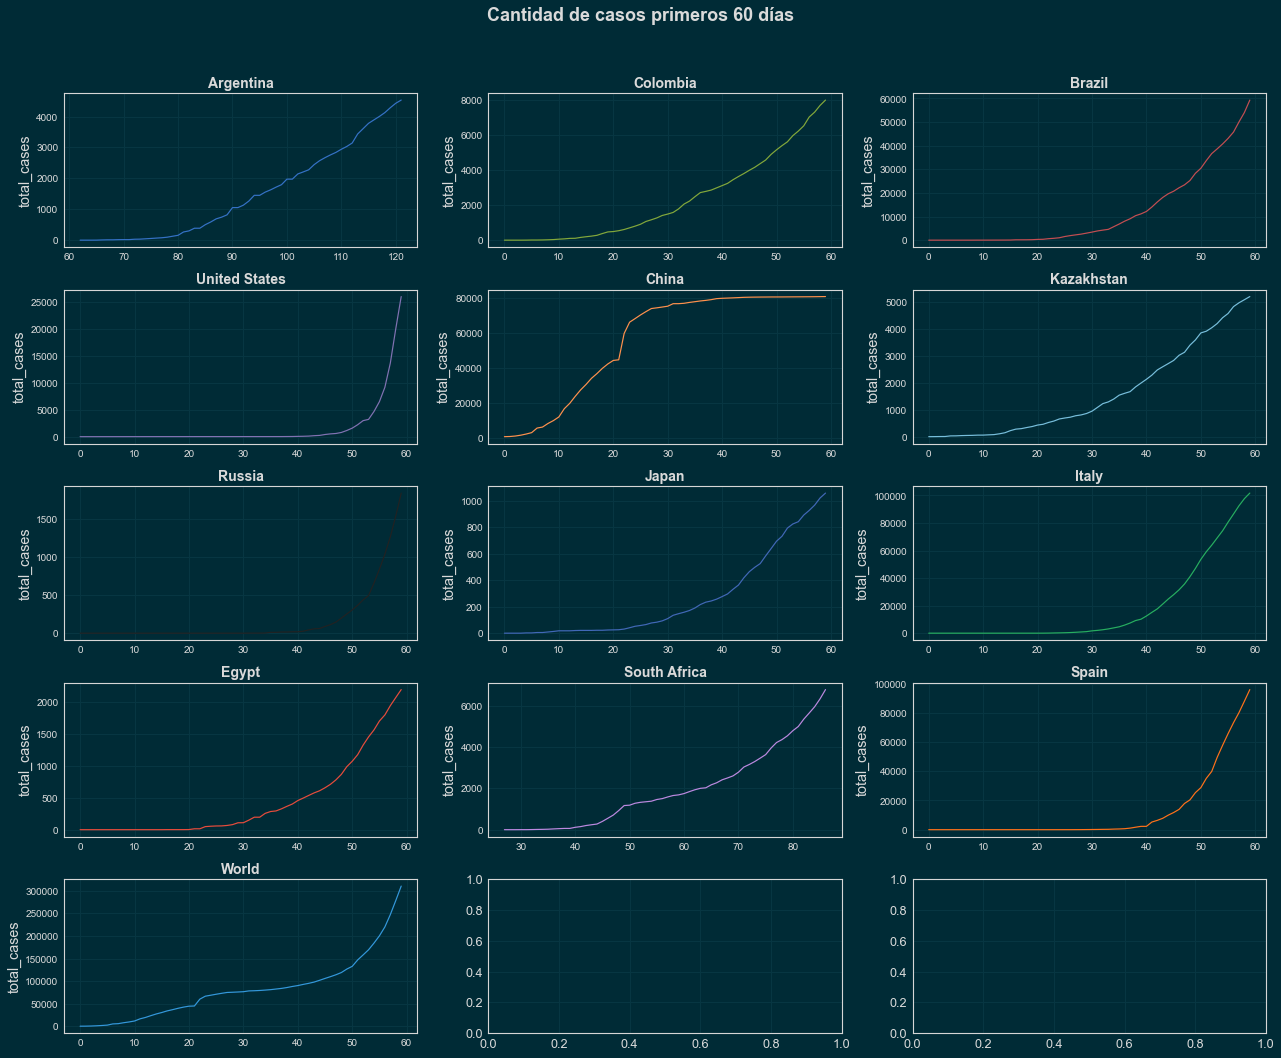

In [10]:
#primeros 60 días

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_p=np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    df = datos[datos.location == p]
    l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_p[l_i:l_i+60]
    dias_principio=dias[l_i:l_i+60]
    
    sns.lineplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica, ya que el comportamiento exponencial pasa a ser lineal.

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

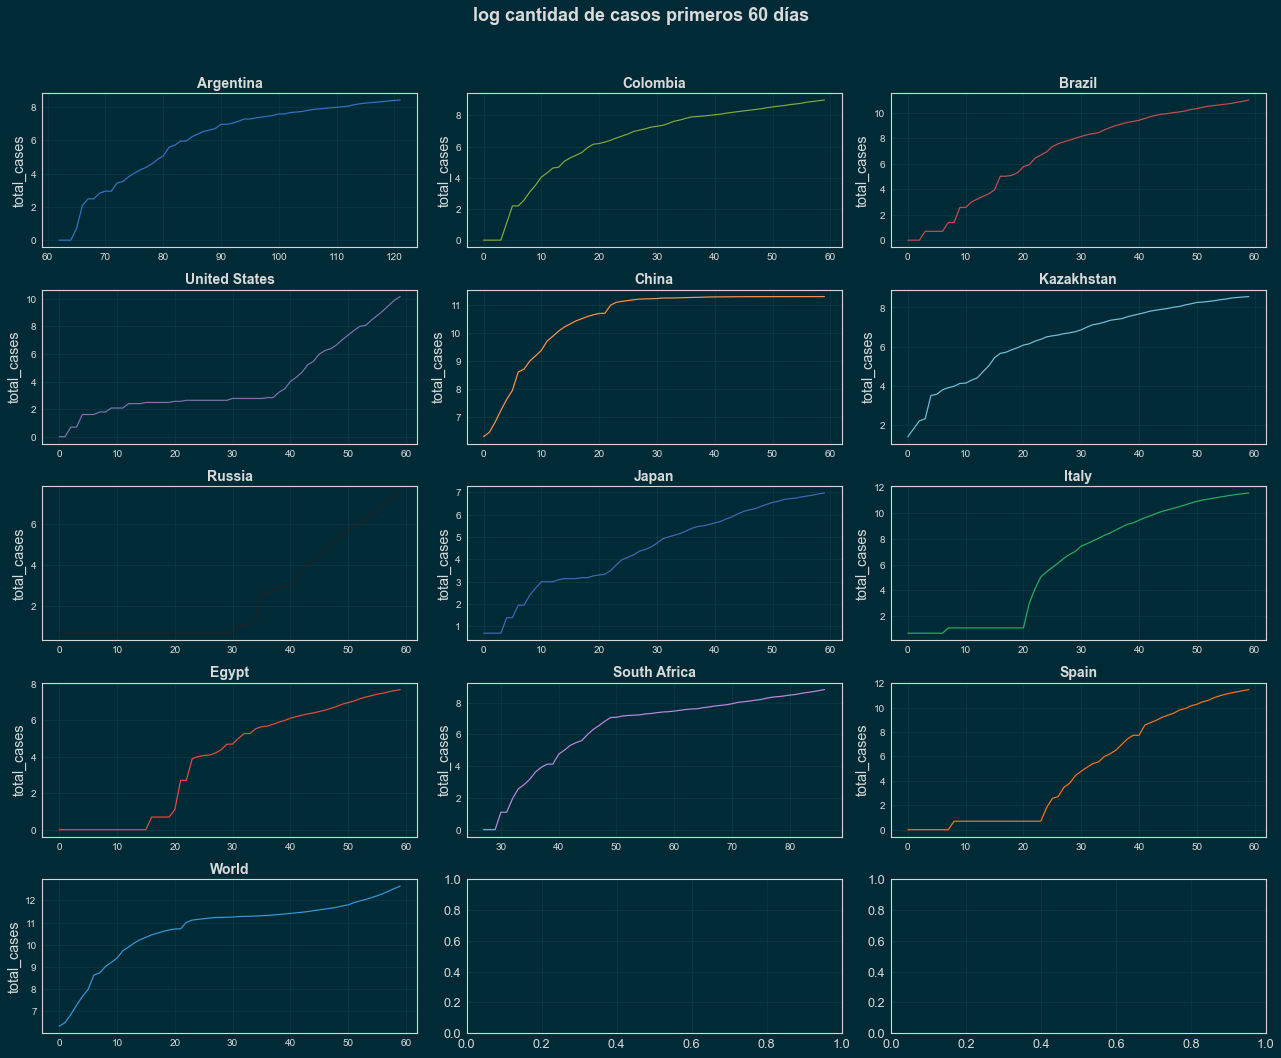

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    
    df = datos[datos.location == p]
    l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[l_i:l_i+60]
    dias_principio=dias[l_i:l_i+60]
    
    sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Seleccionamos rangos especificos de días para cada país, en los que se muestra un comportamiento más sostenido.

In [12]:
# Limites

limites_i = [66,36,44,37,0,17,45,32,30,36,49,29,45]
limites_s = [90,60,60,60,15,60,60,52,50,60,60,39,60]

df_parametros = pd.DataFrame({'Pais': Paises, 't0': limites_i, 'tf':limites_s})
df_parametros

,Pais,t0,tf
0,Argentina,66,90
1,Colombia,36,60
2,Brazil,44,60
3,United States,37,60
4,China,0,15
5,Kazakhstan,17,60
6,Russia,45,60
7,Japan,32,52
8,Italy,30,50
9,Egypt,36,60


Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

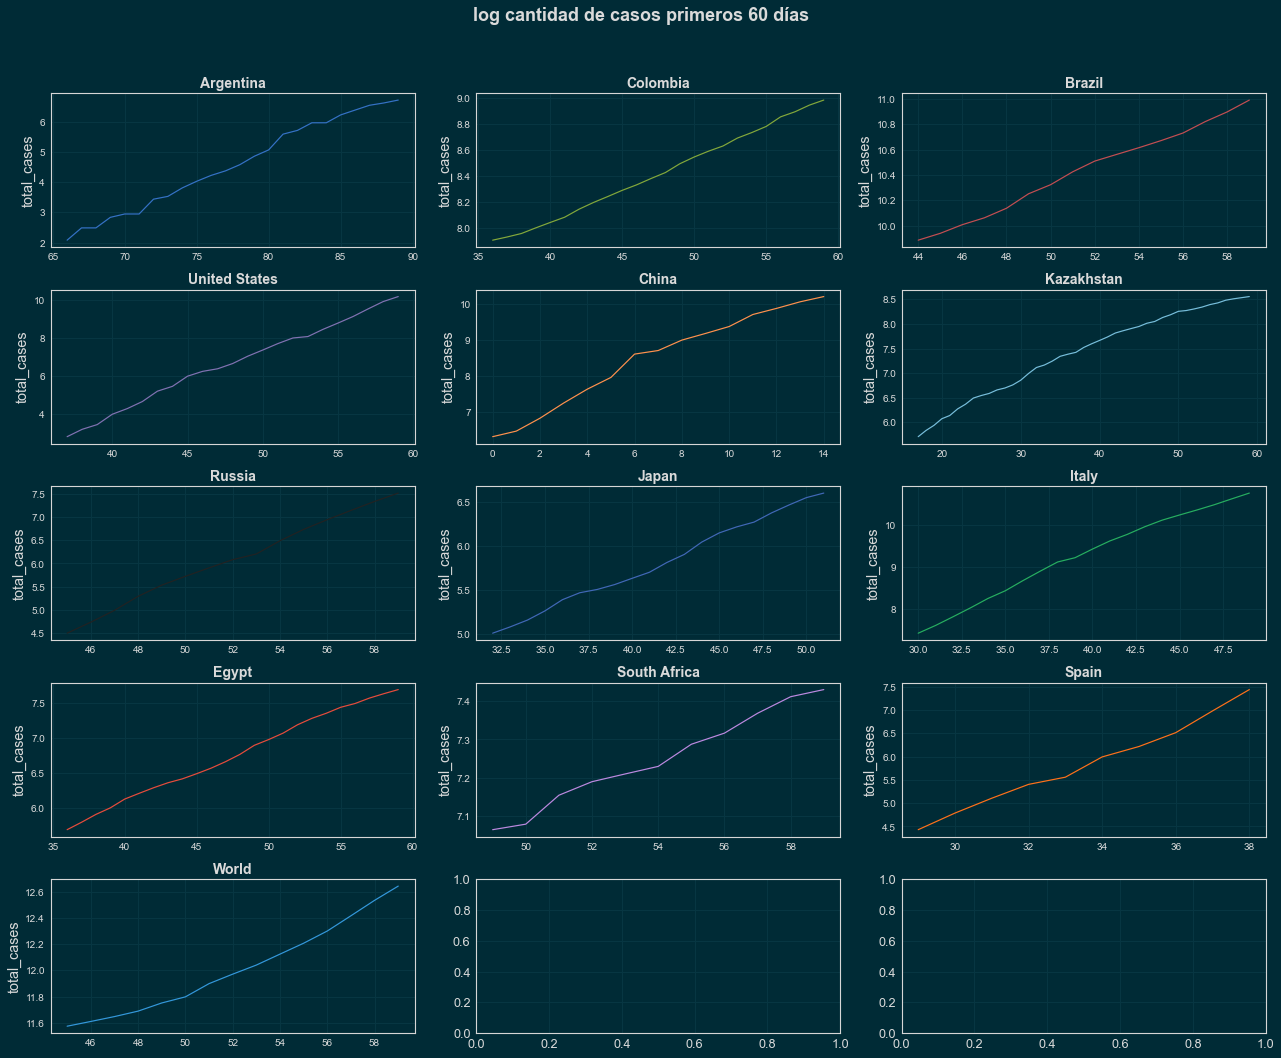

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

En general vemos una linealidad. Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



#### Extracción del  $k$

In [14]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [15]:
t_0 = []
k = []
for j,p in enumerate(Paises):
    ind_p =np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
    
    t_0.append(popt[1])
    k.append(popt[0])
df_parametros['k´s'] = k
#df_parametros = pd.DataFrame({'Pais': Paises, 'k´s': k, 't_0´s':t_0})
df_parametros
    #print(p,'---->',f'k = {popt[0]},',f't_0 = {popt[1]}')
    #print('--------------------------------------------------------------------')

,Pais,t0,tf,k´s
0,Argentina,66,90,0.050696
1,Colombia,36,60,0.067510
2,Brazil,44,60,0.082312
3,United States,37,60,0.069119
4,China,0,15,0.220378
5,Kazakhstan,17,60,0.049051
6,Russia,45,60,0.084539
7,Japan,32,52,0.033192
8,Italy,30,50,0.026840
9,Egypt,36,60,0.067510


Veamos cómo se ajusta lo que obtuvimos a los datos reales

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

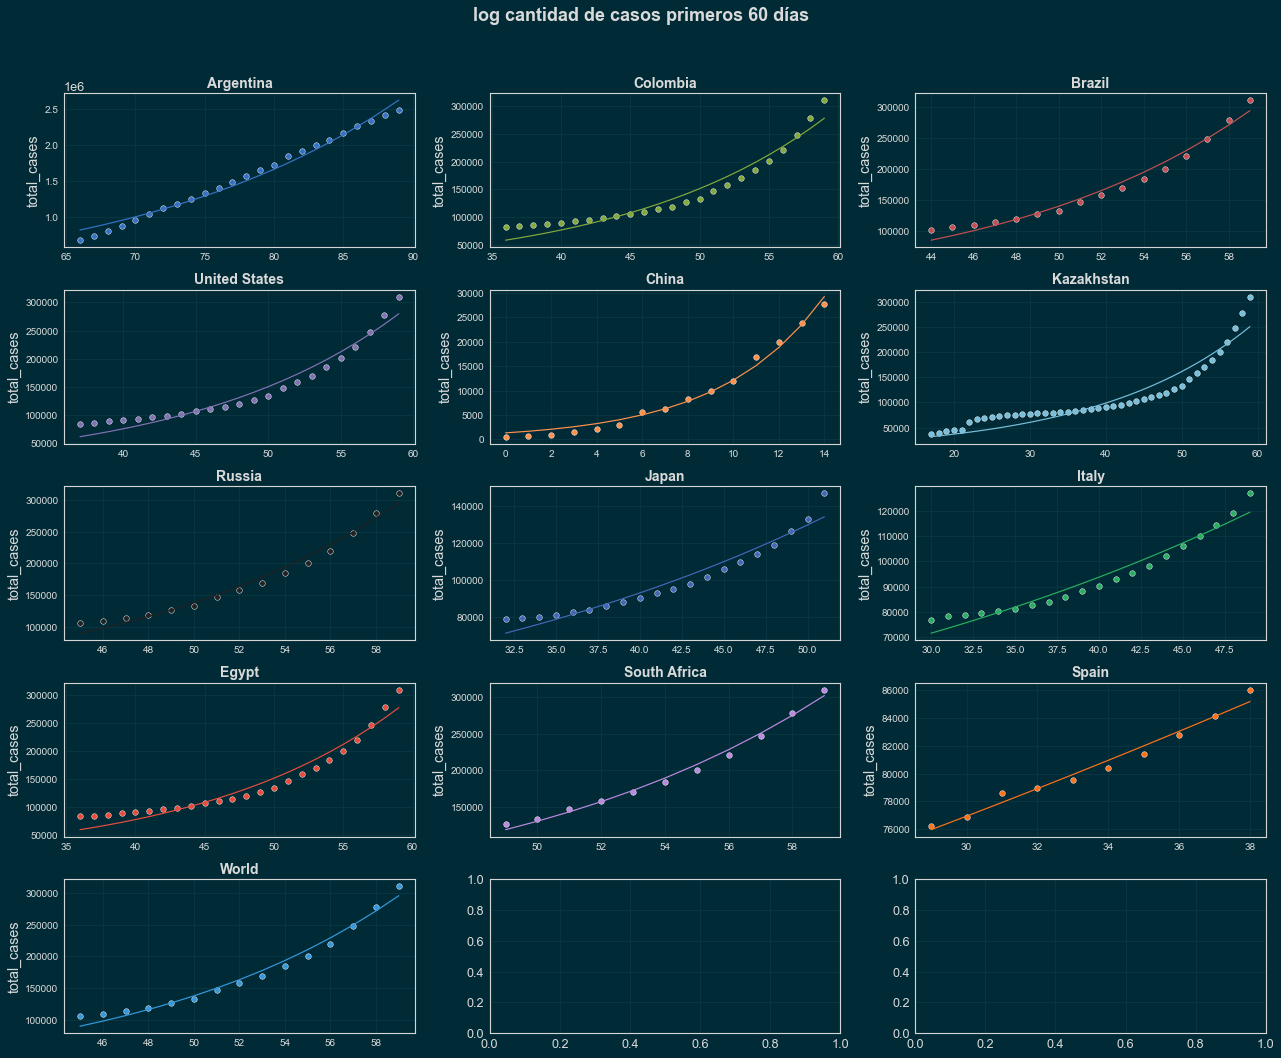

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_p=np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    casos_simu=exponencial(dias_principio,k[j],t_0[j])
    sns.scatterplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    sns.lineplot(x=dias_principio, y=casos_simu,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

In [23]:
df_parametros.iloc[:12].agg(func='mean')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\pandas\core\apply.py:577: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(*args, **kwargs)


t0     35.083333
tf     55.500000
k´s     0.071461
dtype: float64

In [26]:
df_parametros.iloc[:12]['k´s'].mean()

0.07146114076504938

In [27]:
df_parametros.iloc[:12]['t0'].mean()

35.083333333333336

In [28]:
datos.shape[0]

165408

<AxesSubplot:ylabel='total_cases'>

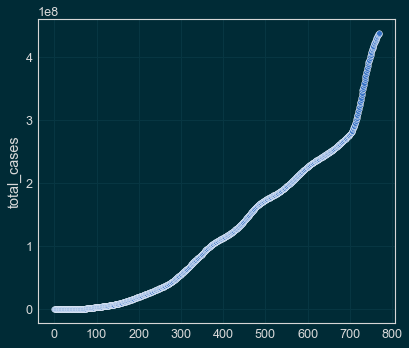

In [43]:
#casos_principio=casos_arg[limites_i[j]:limites_s[j]]
casos_principio=casos_arg[0:1000]
dias_principio=np.arange(770)

casos_simu=exponencial(dias_principio,df_parametros.iloc[:12]['k´s'].mean(),35)
sns.scatterplot(x=dias_principio, y=casos_principio,
#    color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
    #line_kws= {'linewidth': 2},
    alpha   = 1.0)
#sns.lineplot(x=dias_principio, y=casos_simu,
    #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
    #line_kws= {'linewidth': 2},
#    alpha   = 1.0)

#### Intervalo de confianza k's

 Generar un intervalo de confianza para el valor $k$ midiéndolo para varios países, con el objetivo de representar la población mundial con la selección que se haga.

In [44]:
def bootstrap_simplificado(dataset, B=100):
    boots = []
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

In [45]:
datos_boots = bootstrap_simplificado(df_parametros['k´s'],100)
datos_boots

array([[0.22037817, 0.06911866, 0.22037817, ..., 0.22037817, 0.08453852,
        0.08453852],
       [0.03319188, 0.22037817, 0.05069558, ..., 0.02683981, 0.01271024,
        0.08231242],
       [0.05069558, 0.08231242, 0.08453852, ..., 0.05069558, 0.09367756,
        0.06750975],
       ...,
       [0.02683981, 0.05069558, 0.09367756, ..., 0.06750975, 0.02683981,
        0.06750975],
       [0.06750975, 0.08453852, 0.09367756, ..., 0.02683981, 0.09367756,
        0.06911866],
       [0.08453852, 0.08453852, 0.02683981, ..., 0.09367756, 0.08231242,
        0.06750975]])

k_final=0.07234625261645446


Text(0, 0.5, 'Muestras')

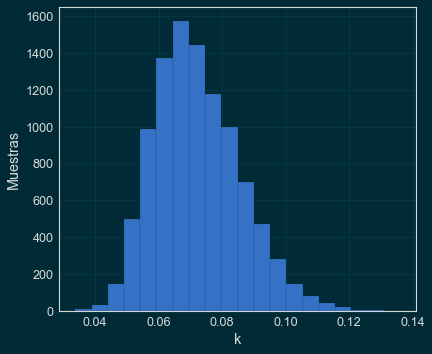

In [46]:
# Bootstrapping

datos_boots = bootstrap_simplificado(df_parametros['k´s'],10000)
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
print(f"k_final={medias.mean()}")
plt.hist(medias, bins=20)
plt.xlabel("k")
plt.ylabel("Muestras")

In [47]:
# Construccion del intervalo de confianza
alpha = 5
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias, (100-alpha/2))
intervalo_confianza = [inferior, superior]
print(f"Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: {intervalo_confianza}")

Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: [0.04994518679371367, 0.10204740405895972]


### c. Criterio de elección
Los países seleccionados fueron elegidos de un entorno cercano de china y otros con una comunicación fuerte con china o países del entrono cercano.

### d. World

<AxesSubplot:ylabel='total_cases'>

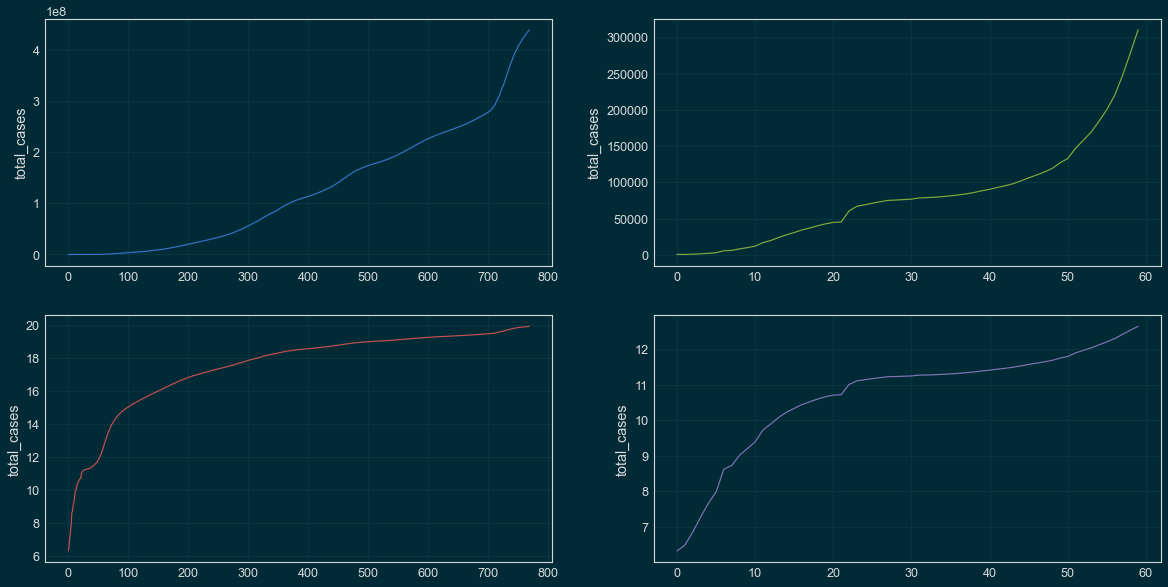

In [50]:
ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
dias=np.arange(0,len(casos_world))

df = datos[datos.location == 'World']
l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
casos_principio=casos_world[l_i:l_i+60]
dias_principio=dias[l_i:l_i+60]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flat
sns.lineplot(x=dias, y=casos_world,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0)

sns.lineplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0)

sns.lineplot(x=dias, y=np.log(casos_world),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[2]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[2])

sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[3]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[3])

<AxesSubplot:ylabel='total_cases'>

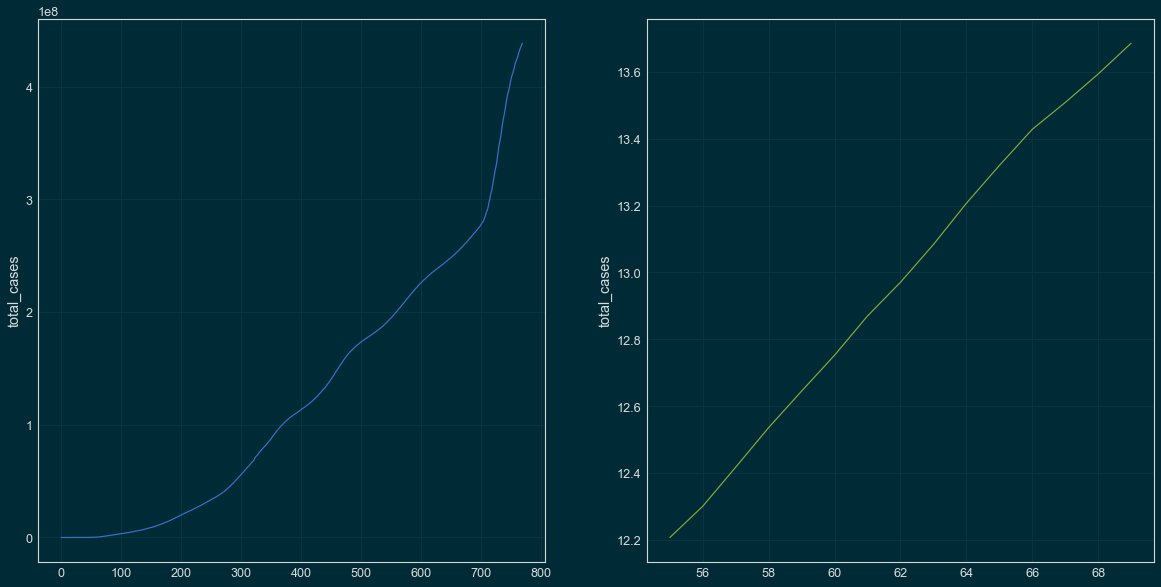

In [52]:
df = datos[datos.location == 'World']
l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
casos_principio=casos_world[55:70]
dias_principio=dias[55:70]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flat
sns.lineplot(x=dias, y=casos_world,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0)

sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0)

In [56]:
casos_principio=casos_world[0:70]
dias_principio=dias[0:70]
    
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
k_world = popt[0]
t0_world = popt[1]
print(k_world, t0_world)

0.09093508452667731 -81.18221169189633


<AxesSubplot:ylabel='total_cases'>

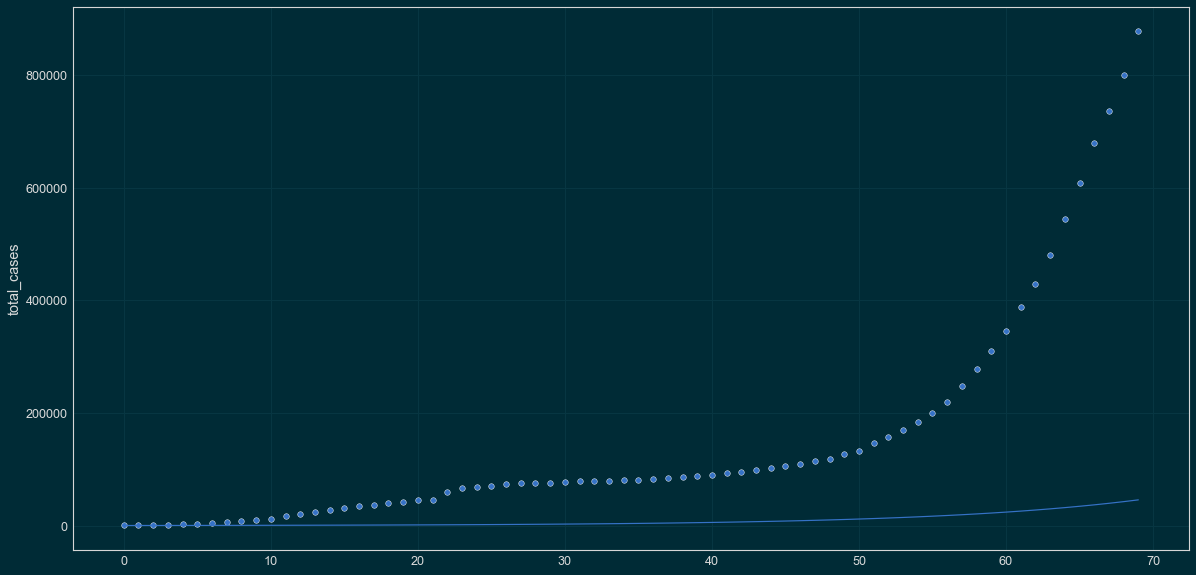

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
casos_simu=exponencial(dias_principio,df_parametros.iloc[:12]['k´s'].mean(),t0_world)
sns.scatterplot(x=dias_principio, y=casos_principio,
    #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
    #line_kws= {'linewidth': 2},
    alpha   = 1.0)
sns.lineplot(x=dias_principio, y=casos_simu,
    #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
    #line_kws= {'linewidth': 2},
    alpha   = 1.0)

El $k$ promedio de los paises seleccionados ( $k = 0,071461$), no es el más adecuado para hacer inferencias sobre la población mundial como lo muestra la gráfica. Algunas de las razones pueden ser:
 * La cantidad de paises seleccionados no es una muestra representativa;
 * los paises seleccionados no recopilan el comportamiento general;
 * La ventana de tiempo analizada, aún no evidenciaba la tendencia del comportamiento poblacional;
 * Quedaron por fuera paises que tienen un impacto imporante en el comportamiento poblacional.

### e. Gráficos

In [115]:
df_world = datos[datos.location == 'World']
df_world = df_world.loc[:,['date','new_cases', 'new_deaths']]
df_world

,date,new_cases,new_deaths
162521,2020-01-22,0.0,0.0
162522,2020-01-23,98.0,1.0
162523,2020-01-24,286.0,8.0
162524,2020-01-25,493.0,16.0
162525,2020-01-26,684.0,14.0
...,...,...,...
163286,2022-02-25,1592363.0,9118.0
163287,2022-02-26,1329595.0,6422.0
163288,2022-02-27,1066130.0,4426.0
163289,2022-02-28,1403459.0,7762.0


<AxesSubplot:xlabel='date', ylabel='new_deaths'>

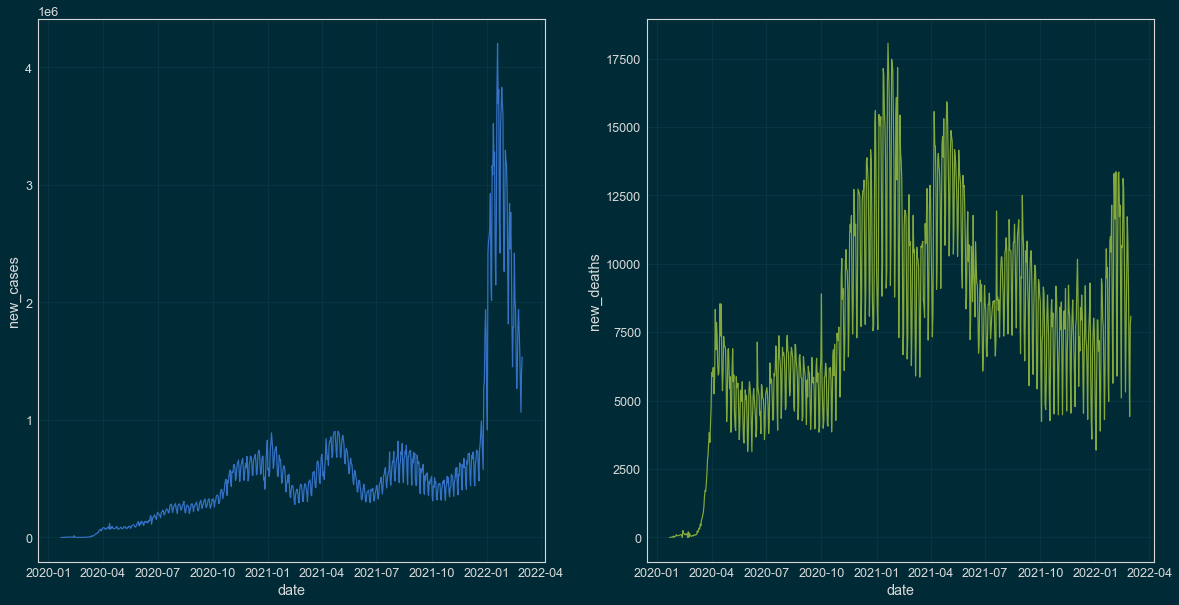

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flat
sns.lineplot(x="date", y="new_cases",
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0, data=df_world)

sns.lineplot(x="date", y="new_deaths",
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0, data=df_world)

In [117]:
df_world.insert(1,'Year',df_world['date'].dt.year,True)
df_world.insert(2,'Month',df_world['date'].dt.month,True)
df_world.insert(3,'Day',df_world['date'].dt.day,True)

#df_world['Year'] = df_world['date'].dt.year
#df_world['Month'] = df_world['date'].dt.month
df_world.drop(columns=['date'],inplace=True)
df_world.index = range(len(df_world.index))
df_world

,Year,Month,Day,new_cases,new_deaths
0,2020,1,22,0.0,0.0
1,2020,1,23,98.0,1.0
2,2020,1,24,286.0,8.0
3,2020,1,25,493.0,16.0
4,2020,1,26,684.0,14.0
...,...,...,...,...,...
765,2022,2,25,1592363.0,9118.0
766,2022,2,26,1329595.0,6422.0
767,2022,2,27,1066130.0,4426.0
768,2022,2,28,1403459.0,7762.0


In [118]:
keys = np.arange(1,13)
values = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Ww_mapping = dict(zip(keys, values))
#Ww_mapping={ 
#    1: 'Enero', 
#    2: 'Febrero', 
#    3: 'Marzo', 
#    4: 'Abril',
#    5: 'Mayo', 
#    6: 'Junio',
#    7: 'Julio', 
#    8: 'Agosto', 
#    9: 'Septiembre', 
#    10: 'Octubre',
#    11: 'Noviembre', 
#    12: 'Diciembre'
#}
df_world.insert(1,'month',df_world.Month.map(Ww_mapping),True)
df_world.drop(columns=['Month'],inplace=True)
#df_world['Mes_name']=df_world.Month.map(Ww_mapping)
df_world

,Year,month,Day,new_cases,new_deaths
0,2020,Jan,22,0.0,0.0
1,2020,Jan,23,98.0,1.0
2,2020,Jan,24,286.0,8.0
3,2020,Jan,25,493.0,16.0
4,2020,Jan,26,684.0,14.0
...,...,...,...,...,...
765,2022,Feb,25,1592363.0,9118.0
766,2022,Feb,26,1329595.0,6422.0
767,2022,Feb,27,1066130.0,4426.0
768,2022,Feb,28,1403459.0,7762.0


In [120]:
cats = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
raw_cat = pd.Categorical(
    df_world.month, categories=cats, ordered=True
)
#df_world.index = pd.CategoricalIndex(df_world.month, categories=cats, ordered=True)
#df_world.sort_index().reset_index(drop=True)
df_world['month'] = raw_cat
#df_world.sort_values(by='month')
df_world


,Year,month,Day,new_cases,new_deaths
0,2020,Jan,22,0.0,0.0
1,2020,Jan,23,98.0,1.0
2,2020,Jan,24,286.0,8.0
3,2020,Jan,25,493.0,16.0
4,2020,Jan,26,684.0,14.0
...,...,...,...,...,...
765,2022,Feb,25,1592363.0,9118.0
766,2022,Feb,26,1329595.0,6422.0
767,2022,Feb,27,1066130.0,4426.0
768,2022,Feb,28,1403459.0,7762.0


<AxesSubplot:xlabel='Day', ylabel='new_cases'>

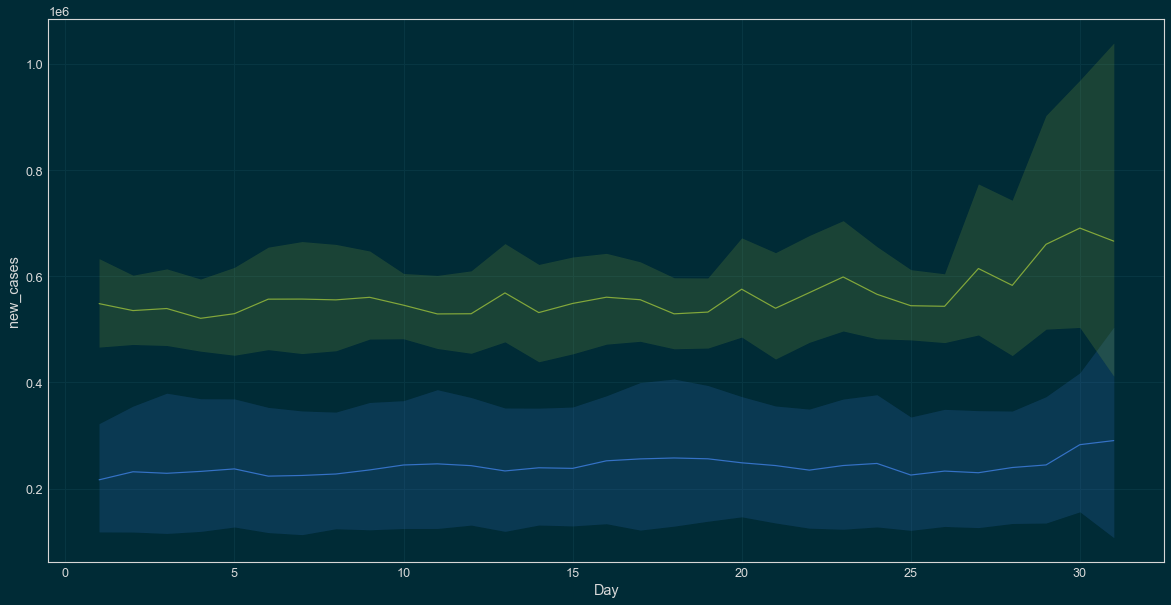

In [122]:
plt.figure(figsize=(20,10))
sns.lineplot(x="Day", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2020])
sns.lineplot(x="Day", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2021])

In [123]:
df_world = df_world[['new_cases','Year','month']].groupby(['Year','month']).sum().sort_values(by=['Year','month'], ascending=False)
df_world = df_world.reset_index(level=['Year','month'])
df_world.sort_values(by=['Year','month'])

,Year,month,new_cases
35,2020,Jan,9370.0
34,2020,Feb,76104.0
33,2020,Mar,791312.0
32,2020,Apr,2432267.0
31,2020,May,2905432.0
30,2020,Jun,4316759.0
29,2020,Jul,7119556.0
28,2020,Aug,7944426.0
27,2020,Sep,8503353.0
26,2020,Oct,12120307.0


<AxesSubplot:xlabel='month', ylabel='new_cases'>

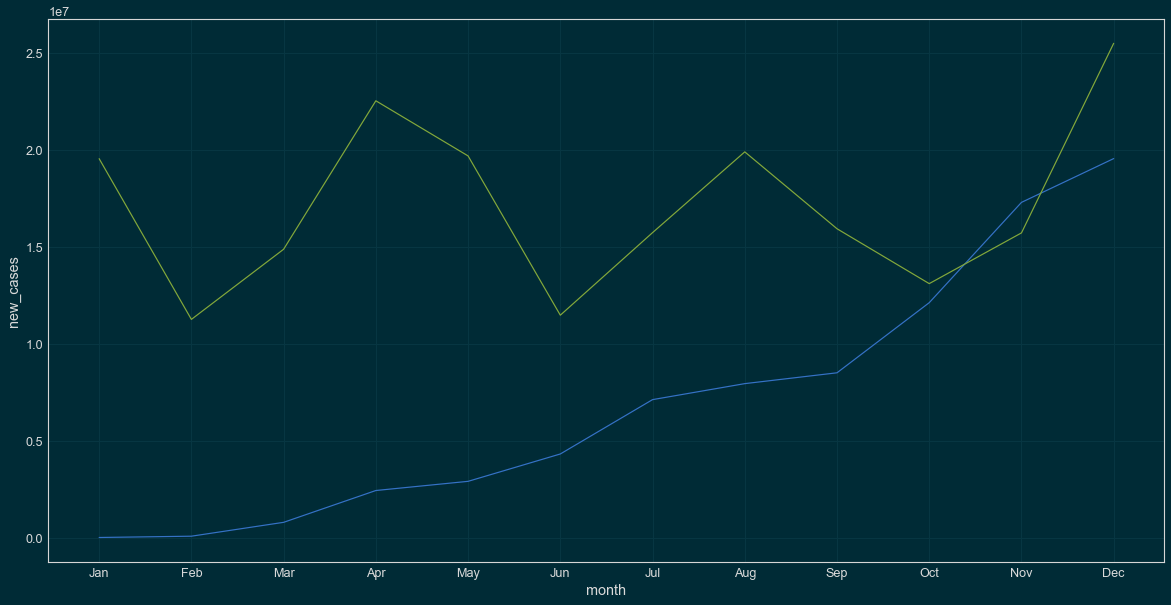

In [124]:
plt.figure(figsize=(20,10))
sns.lineplot(x="month", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2020])
sns.lineplot(x="month", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2021])

In [125]:
df_world_wide = df_world.pivot("Year", "month", "new_cases")
df_world_wide.head()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2020,9370.0,76104.0,791312.0,2432267.0,2905432.0,4316759.0,7119556.0,7944426.0,8503353.0,12120307.0,17292653.0,19551704.0
2021,19546555.0,11257458.0,14874973.0,22532134.0,19688882.0,11474633.0,15731711.0,19897859.0,15932965.0,13102567.0,15718804.0,25496533.0
2022,89441989.0,58062642.0,1536093.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='Year'>

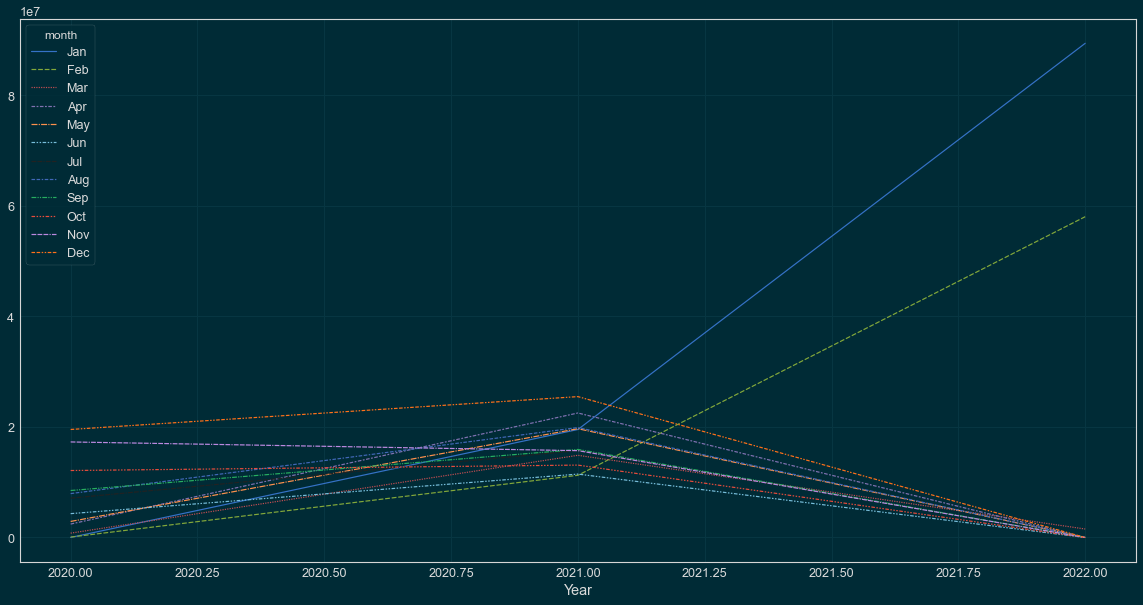

In [126]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_world_wide)

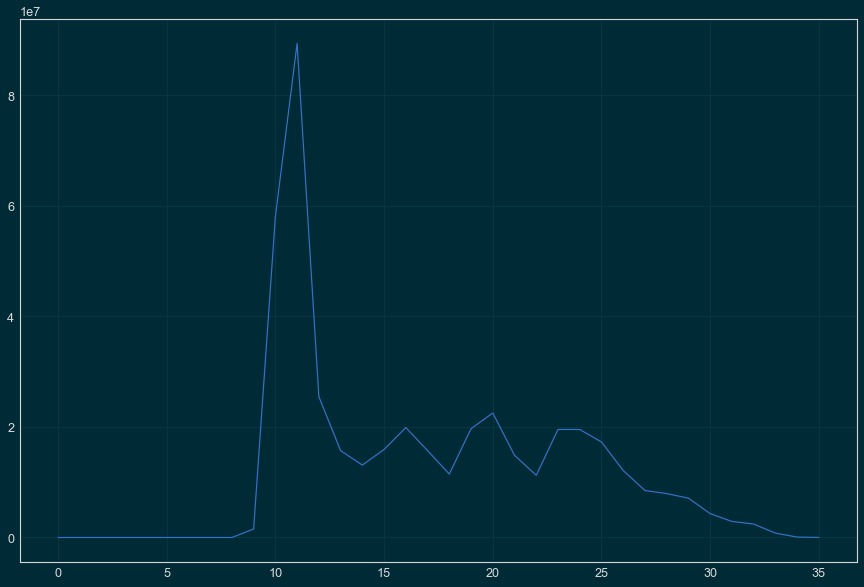

In [143]:
plt.figure(figsize=(15,10))
plt.plot(df_world['new_cases'])

<Figure size 1080x720 with 0 Axes>

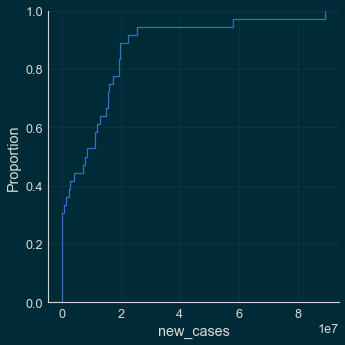

In [131]:
#sns.displot(df_world, x='total_cases', kind="kde")
plt.figure(figsize=(15,10))
sns.displot(df_world, x='new_cases', kind="ecdf")

# Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".

# Por paises

In [26]:
df_arg = datos[datos.location == 'South Africa']
df_arg#[0:28]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
137214,ZAF,Africa,South Africa,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137215,ZAF,Africa,South Africa,2020-02-08,NaN,NaN,NaN,NaN,NaN,NaN,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137216,ZAF,Africa,South Africa,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN,...,8.1,33.2,43.993,2.32,64.13,0.709,1580.2,2.82,8.13,26.318246
137217,ZAF,Africa,South Africa,2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137218,ZAF,Africa,South Africa,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137963,ZAF,Africa,South Africa,2022-02-25,3669671.0,2111.0,2121.000,99145.0,127.0,121.000,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137964,ZAF,Africa,South Africa,2022-02-26,3671991.0,2320.0,2128.571,99191.0,46.0,82.000,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137965,ZAF,Africa,South Africa,2022-02-27,3673257.0,1266.0,2101.429,99229.0,38.0,80.286,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN
137966,ZAF,Africa,South Africa,2022-02-28,3674042.0,785.0,2049.143,99412.0,183.0,86.857,...,8.1,33.2,43.993,2.32,64.13,0.709,NaN,NaN,NaN,NaN


## China

In [ ]:
for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p) #indises de pais de interes
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    #plt.figure(figsize = (15,8))
    #plt.plot(dias,casos_arg)
    #plt.xlabel('dias')
    #plt.ylabel('cantidad de casos')
    sns.lineplot(x=dias, y=casos_arg,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #markers=True,
        #dashes=True,
        #legend="full",
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
#fig.tight_layout()
#plt.subplots_adjust(top = 0.9)
#fig.suptitle('Casos Totales', fontsize = 18, fontweight = "bold")

Text(0, 0.5, 'log cantidad de casos')

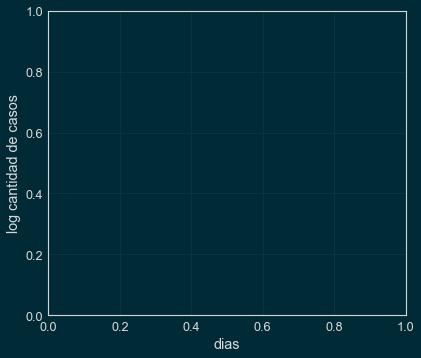

In [44]:

plt.plot,np.log(casos_principio)
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

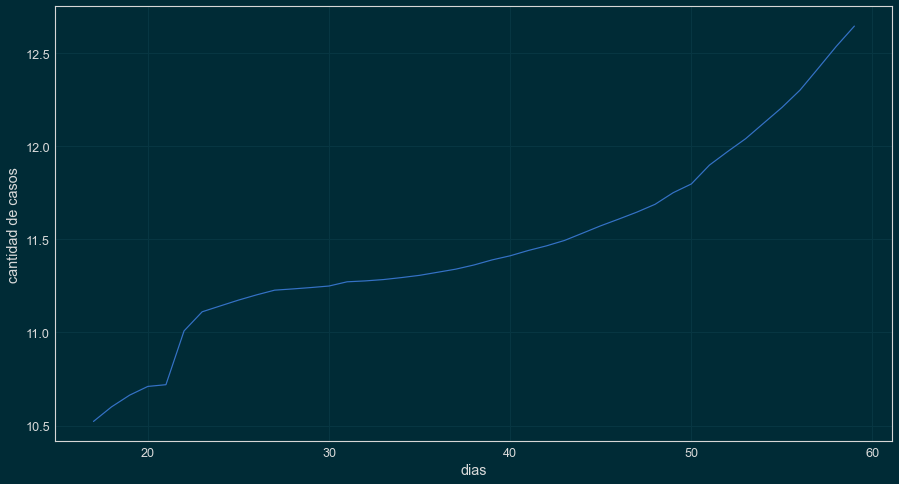

In [45]:
ind_p=np.where(paises=='World')
ind_p=ind_p[0]
casos_p=confirmados[ind_p]
dias=np.arange(0,len(casos_p))
    
#df = datos[datos.location == p]
#l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name

casos_principio=casos_p[17:60]
dias_principio=dias[17:60]

#casos_principio=casos_arg[60:95]
#dias_principio=dias[60:95]

plt.figure(figsize = (15,8))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

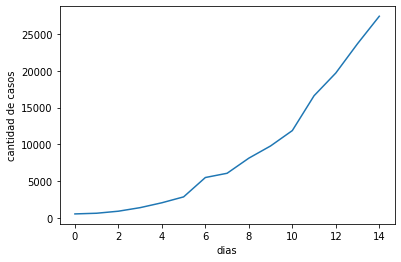

In [29]:
casos_principio=casos_arg[0:15]
dias_principio=dias[0:15]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

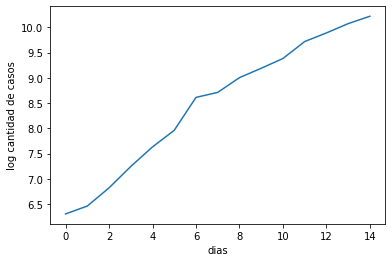

In [30]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

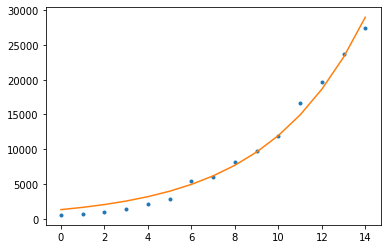

In [37]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [38]:
def casos_nuevos(casos):
    nuevos=np.zeros(len(casos))
    i=0
    while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

    return nuevos   

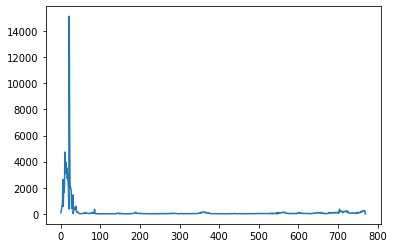

In [39]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

## Mongolia

In [43]:
df_mon = datos[datos.location == 'Mongolia']
df_mon

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
100110,MNG,Asia,Mongolia,2020-03-10,1.0,1.0,NaN,NaN,NaN,NaN,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100111,MNG,Asia,Mongolia,2020-03-11,1.0,0.0,NaN,NaN,NaN,NaN,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100112,MNG,Asia,Mongolia,2020-03-12,1.0,0.0,NaN,NaN,NaN,NaN,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100113,MNG,Asia,Mongolia,2020-03-13,1.0,0.0,NaN,NaN,NaN,NaN,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100114,MNG,Asia,Mongolia,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100827,MNG,Asia,Mongolia,2022-02-25,905968.0,1737.0,1749.571,2167.0,0.0,1.429,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100828,MNG,Asia,Mongolia,2022-02-26,905968.0,0.0,1749.571,2168.0,1.0,1.286,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100829,MNG,Asia,Mongolia,2022-02-27,905968.0,0.0,1749.571,2168.0,0.0,1.286,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN
100830,MNG,Asia,Mongolia,2022-02-28,908157.0,2189.0,1307.857,2170.0,2.0,1.571,...,5.5,46.5,71.18,7.0,69.87,0.737,NaN,NaN,NaN,NaN


In [44]:
# Primer caso no nulo index
df_mon.total_cases.isnull().idxmin()-df_mon.iloc[0].name

0

Text(0, 0.5, 'cantidad de casos')

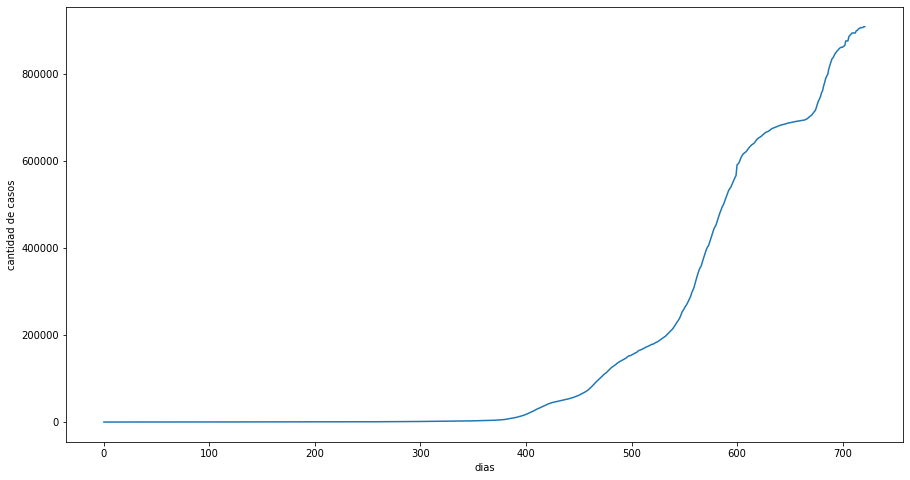

In [45]:
#seleccionamos Mongolia

ind_arg=np.where(paises=='Mongolia')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.figure(figsize = (15,8))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

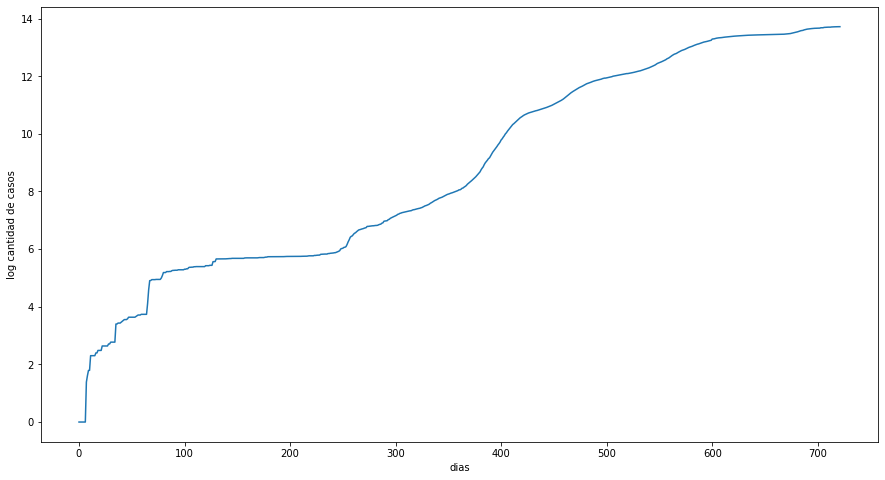

In [46]:
plt.figure(figsize = (15,8))
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

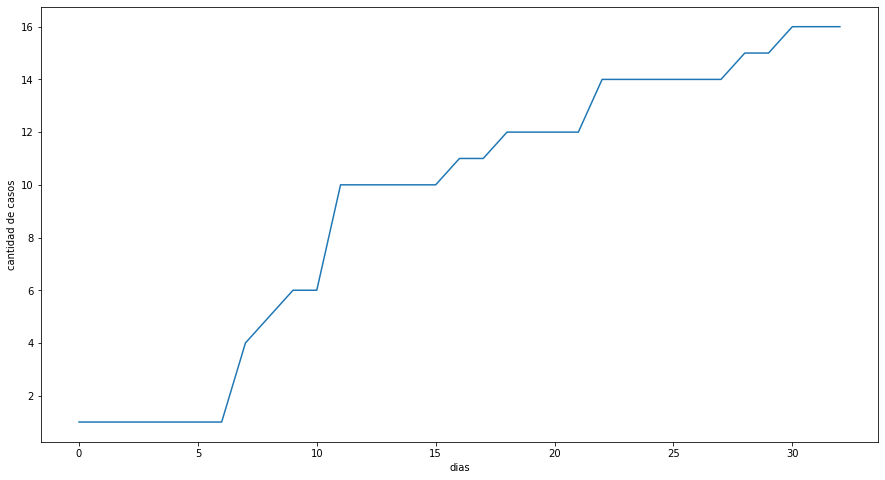

In [49]:
casos_principio=casos_arg[0:33]
dias_principio=dias[0:33]

plt.figure(figsize = (15,8))
plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

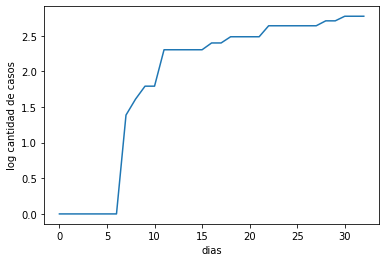

In [50]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

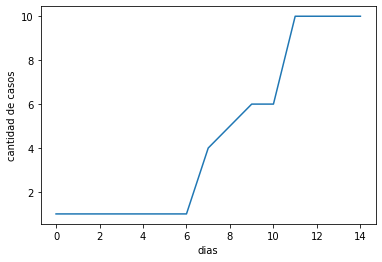

In [51]:
casos_principio=casos_arg[0:15]
dias_principio=dias[0:15]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

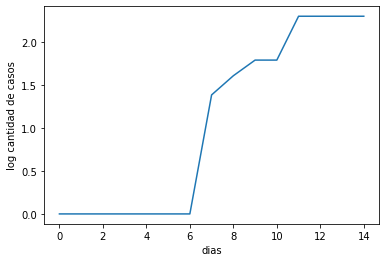

In [52]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [53]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.17402402, -0.32631215])

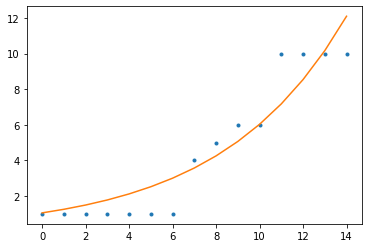

In [54]:

k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

## Colombia

In [6]:
df_col = datos[datos.location == 'Colombia']
df_col

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
32128,COL,South America,Colombia,2020-03-06,1.0,1.0,NaN,NaN,NaN,NaN,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32129,COL,South America,Colombia,2020-03-07,1.0,0.0,NaN,NaN,NaN,NaN,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32130,COL,South America,Colombia,2020-03-08,1.0,0.0,NaN,NaN,NaN,NaN,...,4.7,13.5,65.386,1.71,77.29,0.767,543.2,1.15,-1.48,10.595749
32131,COL,South America,Colombia,2020-03-09,1.0,0.0,NaN,NaN,NaN,NaN,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32132,COL,South America,Colombia,2020-03-10,3.0,2.0,NaN,NaN,NaN,NaN,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32849,COL,South America,Colombia,2022-02-25,6058715.0,2159.0,2793.143,138501.0,80.0,90.286,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32850,COL,South America,Colombia,2022-02-26,6060793.0,2078.0,2447.429,138598.0,97.0,86.000,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32851,COL,South America,Colombia,2022-02-27,6062701.0,1908.0,2237.000,138693.0,95.0,83.857,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN
32852,COL,South America,Colombia,2022-02-28,6064583.0,1882.0,2090.143,138767.0,74.0,80.286,...,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN,NaN


In [8]:
# Primer caso no nulo index
df_col.total_cases.isnull().idxmin()-df_col.iloc[0].name

0

In [9]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

Text(0, 0.5, 'cantidad de casos')

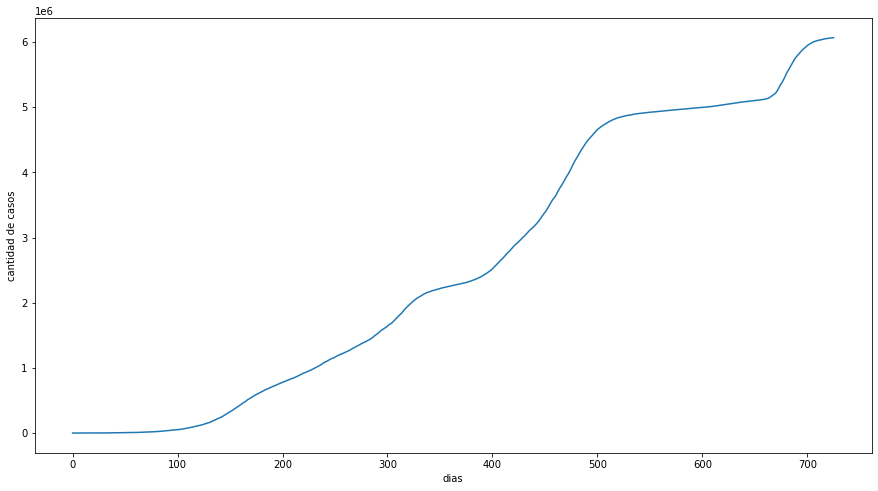

In [10]:
#seleccionamos China

ind_arg=np.where(paises=='Colombia')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.figure(figsize = (15,8))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

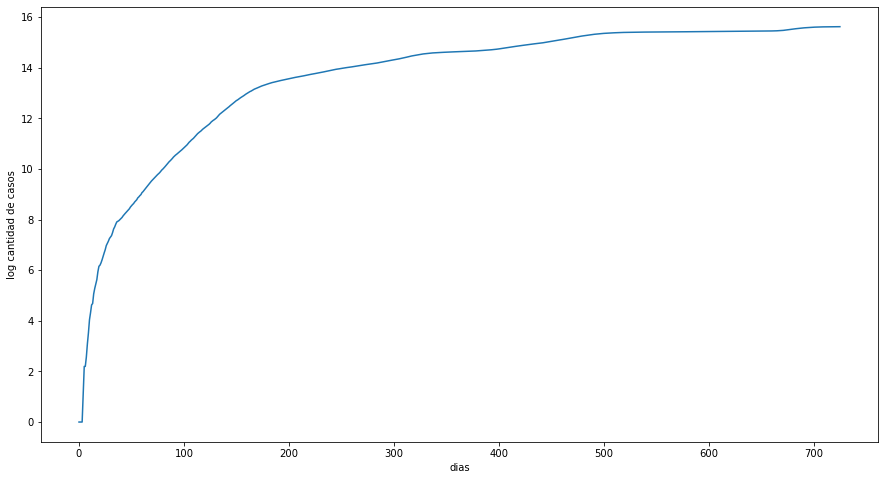

In [11]:
plt.figure(figsize = (15,8))
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [ ]:
casos_principio=casos_arg[0:60]
dias_principio=dias[0:60]

plt.figure(figsize = (15,8))
plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')